# Agentic RAG로 지능형 정보 검색 시스템 만들기 

- 사용자의 질문 입력 -> 에이전트는 적절한 도구를 사용하여 정보를 검색 
- 이를 기반으로 답변을 생성 
- 에이전트는 검색 결과의 관련성을 평가 한 이후, 경우에 따라 질문을 재작성하여 더 정확한 정보 제공

In [3]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
urls = [
    "https://finance.naver.com/",
    "https://finance.yahoo.com/",
    "https://finance.daum.net/",
]

In [5]:
docs = [WebBaseLoader(url).load() for url in urls]
    

In [6]:
docs

[[Document(metadata={'source': 'https://finance.naver.com/', 'title': '네이버페이 증권', 'language': 'ko'}, page_content='\n\n\n네이버페이 증권\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n메인 메뉴로 바로가기\n본문으로 바로가기\n\n\n\n\n\n\n\n\n\n\n네이버\n\n\n\n\n\n페이\n\n\n\n\n\n\n증권\n\n\n\n\n\n\n증권 종목명·지수명 검색\n\n\n\n\n\n\n\n검색\n\n\n자동완성\n\n\n\n\n\n\n\n@code@\n@txt@\n@market@\n\n@full_txt@\n@in_code@\n@in_name@\n@in_link@\n@in_market@\n\n\n\n\n\t\t\t\t\t\t\t\t\t\t\t\t공모주와 해외 종목은 모바일 페이지로 이동합니다.\n\t\t\t\t\t\t\t\t\t\t\t\n\n\n\n\n\n\n\n\n\t\t\t\t\t\t\t\t\t\t\t\t현재 자동완성 기능을 사용하고 계십니다.\n\t\t\t\t\t\t\t\t\t\t\t\n\n\n\n\n\n\n\n\n\n\t\t\t\t\t\t\t\t\t\t\t\t자동완성 기능이 활성화되었습니다.\n\t\t\t\t\t\t\t\t\t\t\t\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n증권 홈선택됨\n국내증시\n해외증시\n시장지표\n리서치\n뉴스\nMY\n\n\n\n\n\n\n\n\n\n본문시작\n\n오늘의 코스피/코스닥 지수\n2025년 08월 07일 장중\n코스피 지수 3,217.07 전일대비 상승 18.93 플러스 0.59 퍼센트\n코스닥 지수 805.02 전일대비 상승 1.53 플러스 0.19 퍼센트\n\n\n\n\n\n최근조회종목\nMY STOCK\n\n\n\n최근 조회종목 리스트\n\n\n\n\n\n\n\n\n\n\n\n\n\n주요뉴스\n\n\n"배당 최고세율 

In [7]:
docs_list = [item for sublist in docs for item in sublist]

In [10]:
docs_list2 = []
for sublist in docs:
    for item in sublist:
        docs_list2.append(item)

In [12]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)


In [13]:
doc_splits = text_splitter.split_documents(docs_list)


In [14]:
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)

In [15]:
retriever = vectorstore.as_retriever()

# Agent State 
- 에이전트 상태를 정의 

In [17]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

In [18]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage], add_messages]

## 검색 도구 생성 

In [ ]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    'retrieve_blog_posts',
    '네이버, 야후, 다음의 금융 관련 정보를 검색하고 반환합니다.'
)

tools = [retriever_tool]

## 그래프 작성

In [23]:
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
#from langchain_core.pydantic_v1 import BaseModel, Field
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import tools_condition

In [25]:
#Edges 

def grade_documents(state):
    """ 
    검색된 문서가 질문과 관련이 있는지 평가합니다. 

    Args:
        state : 현재 상태
    Returns :
        str: 문서의 관련성에 따라 다음 노드 결정 ("generate" or "rewrite")
    """
    print("----문서 관련성 평가----")

    class grade(BaseModel):
        """관련성 평가를 위한 이진 점수""" 
        binary_score: str = Field(description="관련성 점수 'yes' 또는 'no")

    model = ChatOpenAI(model='gpt-4o-mini', temperature=0, streaming=True)

    llm_with_tool = model.with_structured_output(grade)

    prompt = PromptTemplate(
        template="""당신은 사용자 질문에 대해서 검색된 문서의 관련성을 평가하는 평가자입니다.
        여기 검색된 문서가 있습니다:
        {context}
        여기 사용자 질문이 있습니다:
        {question}
        문서가 사용자 질문과 관련된 키워드 또는 의미를 포함하면 관련성이 있다고 평가하세요. 
        문서가 질문과 관련이 있는지 여부를 나타내기 위해 'yes' 또는 'no'로 이진 점수를 주세요
        """
    )

    chain = prompt | llm_with_tool

    messages = state['messages']
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content 

    scored_result = chain.invoke({'question': question, 'context' : docs})

    score = scored_result.binary_score

    if score == "yes":
        print("--결정: 문서 관련성 있음--")
        return "generate"
    else:
        print("--결정: 문서 관련성 없음")
        return 'rewrite'
    

In [32]:
tools = [retriever_tool]
def agent(state):
    """
    현재 상태를 기반으로 에이전트 모델을 호출하여 응답을 생성합니다. 
    주어진 질문에 따라 검색 도구를 사용하여 검색을 수행하거나 단순히 종료하기로 결정합니다. 

    Arggs:
        state: 현재 상태 
    Returns:
        dict: 메시지에 에이전트 응답이 추가된 업데이트된 상태 
    """
    messages = state['messages']
    print("에이전트로 전달된 메시지들: ", messages)
    model = ChatOpenAI(model='gpt-4o-mini', temperature=0, streaming=True)
    
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    state['messages'].append(response)
    return state
    

In [33]:
def rewrite(state):
    """
    질문을 재작성(변형)하여 더 나은 질문을 생성합니다.

    Args:
        state (messages): 현재 상태

    Returns:
        dict: 재구성된 질문으로 업데이트된 상태
    """

    print("---질문 변형---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f"""다음 입력을 보고 근본적인 의도나 의미를 파악해보세요.\n
            초기 질문은 다음과 같습니다:
            \n-------\n
            {question}
            \n-------\n
            개선된 질문을 만들어주세요:""",
        )
    ]
    # 평가자
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)
    response = model.invoke(msg)

    # 반환되는 메세지가 올바른지 확인 
    print("Rewrite 단계에서의 응답:", response)

    # 상태 업데이트 - 기존 메시지에 새 메시지를 추가하여 상태를 업데이트
    state["messages"].append(response)
    
    return state

In [34]:
def generate(state):
    """
    답변 생성

    Args:
        state (messages): 현재 상태

    Returns:
         dict: 재구성된 질문으로 업데이트된 상태
    """
    print("---생성---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    # 프롬프트
    # prompt = hub.pull("rlm/rag-prompt")
    # 프롬프트 정의
    prompt = PromptTemplate(
    template="""당신은 질문-답변 작업을 위한 어시스턴트입니다. 
    아래 제공된 문맥을 사용하여 질문에 답변해주세요. 
    답을 모를 경우 '모르겠습니다'라고 말해주세요. 답변은 최대 3문장으로 간결하게 작성하세요.
    
    질문: {question}
    문맥: {context}
    답변: """,
    input_variables=["context", "question"],
    )

    # LLM
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, streaming=True)
    

    # 체인
    rag_chain = prompt | llm | StrOutputParser()

    # 실행
    response = rag_chain.invoke({"context": docs, "question": question})
    
    return {"messages": [response]}

In [35]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

In [36]:
workflow = StateGraph(AgentState)

In [37]:
workflow.add_node("agent", agent)  # 에이전트 노드
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # 검색 도구 노드
workflow.add_node("rewrite", rewrite)  # 질문 재작성 노드
workflow.add_node(
    "generate", generate
)  # 문서가 관련성이 있다고 판단된 후 응답 생성 노드
# 에이전트 노드를 호출하여 검색을 결정합니다.
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    # 에이전트 결정 평가
    tools_condition,
    {
        # 조건 출력을 그래프 내 노드로 변환, 반환 값: 실행 노드
        "tools": "retrieve",
        END: "generate",
    },
)
# 검색 후 문서 관련성 평가
workflow.add_conditional_edges(
    "retrieve",
    # 에이전트 결정 평가
    grade_documents,
    {
        # 조건 출력을 그래프 내 노드로 변환, 반환 값: 실행 노드
        "generate" : "generate",
        "rewrite" : "rewrite"
    }
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")
graph = workflow.compile()


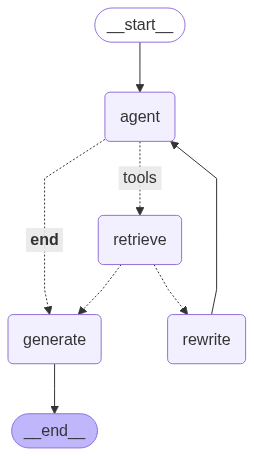

In [39]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [44]:
import pprint 
inputs = {
    'messages': [('user', '금리 전망') ]}


In [45]:
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"노드 '{key}'의 출력 결과:")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

에이전트로 전달된 메시지들:  [HumanMessage(content='금리 전망', additional_kwargs={}, response_metadata={}, id='17ac0fb7-441f-4956-8ad9-aee5445fdd07')]
"노드 'agent'의 출력 결과:"
'---'
{ 'messages': [ HumanMessage(content='금리 전망', additional_kwargs={}, response_metadata={}, id='17ac0fb7-441f-4956-8ad9-aee5445fdd07'),
                AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_caKojpwpkOvRh4U0l4iTxYnm', 'function': {'arguments': '{"query":"금리 전망"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'service_tier': 'default'}, id='run--62bfa2e1-4097-4909-b93d-f460e25510a9-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': '금리 전망'}, 'id': 'call_caKojpwpkOvRh4U0l4iTxYnm', 'type': 'tool_call'}])]}
'\n---\n'
----문서 관련성 평가----
--결정: 문서 관련성 없음
"노드 'retrieve'의 출력 결과:"
'---'
{ 'messages': [ ToolMessage(content='금리\n\n금리종류에 대한 현재가,전일대비